# Deploy SD2.1 to Inferentia2 + SageMaker + HF Optimum Neuron + SageMaker SSH Helper

**SageMaker Studio Kernel**: Python 3 (PyTorch 1.13 Python 3.9 CPU Optimized)  
**Instance**: ml.t3.medium

SageMaker SSH Helper is the "army-knife" library that helps you to securely connect to training jobs, processing jobs, batch inference jobs and realtime inference endpoints as well as SageMaker Studio Notebooks and SageMaker Notebook Instances for fast interactive experimentation, remote debugging, and advanced troubleshooting.


Learn more about remote development and debugging with SageMaker SSH Helper in the GitHub repository: [https://github.com/aws-samples/sagemaker-ssh-helper](https://github.com/aws-samples/sagemaker-ssh-helper)

In this example we use SageMaker SSH Helper to connect to remote endpoint instance running on ml.inf2 instance.

## 1) Update SageMaker SDK

In [ ]:
%pip install -U sagemaker
%pip install matplotlib
%pip install sagemaker-ssh-helper

## 2) Initialize session

In [ ]:
import os
os.environ['AWS_DEFAULT_REGION'] = 'us-east-2'

import sagemaker

print(sagemaker.__version__)
if not sagemaker.__version__ >= "2.146.0": print("You need to upgrade or restart the kernel if you already upgraded")

sess = sagemaker.session.Session()
role = sagemaker.get_execution_role()

bucket = sess.default_bucket()
region = sess.boto_region_name

os.makedirs("src", exist_ok=True)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {bucket}")
print(f"sagemaker session region: {region}")

## 3) Create artifacts to compile & run the model

### 3.1) Dependencies file

In [ ]:
%%writefile src/requirements.txt
evaluate==0.4.0
diffusers==0.21.4
accelerate==0.23.0
scikit-learn==1.3.0
transformers==4.33.1
optimum-neuron==0.0.12
sagemaker-ssh-helper

### 3.2) Python script for compiling and deploying the model

This script will download model weights from HF, compile each module to inf2 and save the compiled artifacts to S3

The envvar **NEURON_RT_NUM_CORES** controls how many NeuronCores are allocated per process. SageMaker can launch multiple processes in just one Endpoint. It means you can increase throughput of your endpoint by deploying your model to a larger instance (inf2.24xlarge or inf2.48xlarge). On an inf2.24xlarge, for instance, SageMaker can deploy 6 copies of the same model in parallel to serve 6 simultaneous clients. This is what we'll do in the next steps.

In [ ]:
%%writefile src/compile.py
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: MIT-0

# See https://github.com/aws-samples/sagemaker-ssh-helper#inference
import os
import sys
sys.path.append(os.path.join(os.path.dirname(__file__), "lib"))
import sagemaker_ssh_helper
sagemaker_ssh_helper.setup_and_start_ssh()


import os
os.environ['NEURON_RT_NUM_CORES'] = '2'
import io
import json
import time
import shutil
import argparse
from filelock import FileLock
from optimum.neuron import NeuronStableDiffusionPipeline

lock_path = '/tmp/new_packages.lock'
lock = FileLock(lock_path)


def model_fn(model_dir, context=None):
    print("Waiting for the lock acquire...")    
    lock.acquire()
    print("Loading model...")
    t = time.time()    
    model = NeuronStableDiffusionPipeline.from_pretrained(model_dir,  device_ids=[0, 1])
    print(f"Model loaded. Elapsed: {time.time()-t}s")
    lock.release()
    return model

    
def input_fn(request_body, request_content_type, context=None):
    if request_content_type == 'application/json':
        req = json.loads(request_body)
        prompt = req.get('prompt')
        num_inference_steps = req.get('num_inference_steps', 50)
        guidance_scale = req.get('guidance_scale', 7.5)
        if prompt is None or type(prompt) != str or len(prompt) < 5:
            raise("Invalid prompt. It needs to be a string > 5")
        if type(num_inference_steps) != int:
            raise("Invalid num_inference_steps. Expected int. default = 50")
        if type(guidance_scale) != float:
            raise("Invalid guidance_scale. Expected float. default = 7.5")
        return prompt, num_inference_steps, guidance_scale
    else:
        raise Exception(f"Unsupported mime type: {request_content_type}. Supported: application/json")


def predict_fn(input_req, model, context=None):
    prompt, num_inference_steps, guidance_scale = input_req
    return model(
        prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale
    ).images[0]


def output_fn(image, accept, context=None):
    if accept != 'image/jpeg':
        raise Exception(f'Invalid data type. Expected image/jpeg, got {accept}')

    buffer = io.BytesIO()
    image.save(buffer, 'jpeg', icc_profile=image.info.get('icc_profile'))
    buffer.seek(0)
    return buffer.read()


if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.    
    parser.add_argument("--model_id", type=str, default="stabilityai/stable-diffusion-2-1-base")
    parser.add_argument("--batch_size", type=int, default=1)
    parser.add_argument("--height", type=int, default=512)
    parser.add_argument("--width", type=int, default=512)
    parser.add_argument("--auto_cast", type=str, default="matmul")
    parser.add_argument("--auto_cast_type", type=str, default="bf16")

    parser.add_argument("--model_dir", type=str, default=os.environ["SM_MODEL_DIR"])
    
    args, _ = parser.parse_known_args()

    model_id = args.model_id
    compiler_args = {"auto_cast": args.auto_cast, "auto_cast_type": args.auto_cast_type}
    input_shapes = {"batch_size": args.batch_size, "height": args.height, "width": args.width}

    print("Compiling model...")    
    t = time.time()
    stable_diffusion = NeuronStableDiffusionPipeline.from_pretrained(
        model_id, export=True, **compiler_args, **input_shapes
    )
    print(f"Done. Elapsed time: {(time.time()-t) * 1000}s")
    print("Saving model...")
    t = time.time()
    stable_diffusion.save_pretrained(args.model_dir)
    print(f"Done. Elapsed time: {(time.time()-t) * 1000}s")

    code_path = os.path.join(args.model_dir, "code")
    os.makedirs(code_path, exist_ok=True)
    shutil.copy("compile.py", os.path.join(code_path, "inference.py"))
    shutil.copy("requirements.txt", os.path.join(code_path, "requirements.txt"))
    print(f"Job done!")

## 4) SageMaker (training) Job that will download and compile the model

**ATTENTION**: You need to run this step only once. Then, you can deploy the compiled model as many times as you need.

In [ ]:
import json
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="compile.py", # Specify your train script
    source_dir="src",
    role=role,
    sagemaker_session=sess,    
    instance_count=1,
    instance_type='ml.trn1.2xlarge',
    output_path=f"s3://{bucket}/output",
    disable_profiler=True,
    disable_output_compression=True,

    image_uri=f"763104351884.dkr.ecr.{region}.amazonaws.com/pytorch-training-neuronx:1.13.1-neuronx-py310-sdk2.13.2-ubuntu20.04",
    
    volume_size = 128,
    hyperparameters={
        "model_id": "stabilityai/stable-diffusion-2-1-base",
    }
)
estimator.framework_version = '1.13.1' # workaround when using image_uri

In [ ]:
# this takes ~66.16mins on a trn1.32xlarge
estimator.fit()

In [ ]:
print("""
If you decide to run this notebook again, you don't need to re-compile the model.
Just keep the following path and use it to deploy the model next time.
""")
print(estimator.model_data)

## 5) Deploy the compiled model to a SageMaker endpoint on inf2
SageMaker can launch multiple workers, depending on the size of the Inf2 instance. A worker is a standalone Python process that manages one copy of the model. SageMaker puts a load balancer on top of all these processes and distributes the load automatically for your clients. It means that you can increase throughput by launching multiple workers, which serve different clients in parallel.

For instance. If you deploy the model to a **ml.inf2.48xlarge**, SageMaker can launch 12 workers with 12 copies of the model. This instance has 24 cores and each copy of the model utilizes 2 cores. Then, you can have 12 simultaneous clients invoking the endpoint and being served at the same time.

In [ ]:
import logging
from sagemaker.utils import name_from_base
from sagemaker.pytorch.model import PyTorchModel

# depending on the inf2 instance you deploy the model you'll have more or less accelerators
# we'll ask SageMaker to launch 1 worker per core

instance_type_idx = 1
instance_types = ['ml.inf2.8xlarge', 'ml.inf2.24xlarge','ml.inf2.48xlarge']
num_cores = [2,12,24]
num_workers = num_cores[instance_type_idx]//2

model_data = estimator.model_data
#model_data = {'S3DataSource': {'S3Uri': 's3://sagemaker-us-east-2-555555555555/output/pytorch-training-neuronx-2023-11-29-15-32-12-256/output/model/', 'S3DataType': 'S3Prefix', 'CompressionType': 'None'}}


print(f"Instance type: {instance_types[instance_type_idx]}. Num SM workers: {num_workers}")
pytorch_model = PyTorchModel(
    image_uri=f"763104351884.dkr.ecr.{region}.amazonaws.com/pytorch-inference-neuronx:1.13.1-neuronx-py310-sdk2.14.1-ubuntu20.04",
    model_data=model_data,
    role=role,    
    name=name_from_base('sd'),
    sagemaker_session=sess,
    container_log_level=logging.DEBUG,
    model_server_workers=num_workers,
    framework_version="1.13.1",
    env = {
        'SAGEMAKER_MODEL_SERVER_TIMEOUT' : '3600',
    },
    # for production, it is important to define vpc_config and use a vpc_endpoint
    #vpc_config={
    #    'Subnets': ['<SUBNET1>', '<SUBNET2>'],
    #    'SecurityGroupIds': ['<SECURITYGROUP1>', '<DEFAULTSECURITYGROUP>']
    #}
)
pytorch_model._is_compiled_model = True

In [ ]:
# See https://github.com/aws-samples/sagemaker-ssh-helper
from sagemaker_ssh_helper.wrapper import SSHModelWrapper
ssh_wrapper = SSHModelWrapper.create(pytorch_model, connection_wait_time_seconds=0)

In [ ]:
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type=instance_types[instance_type_idx],
    model_data_download_timeout=600, # it takes some time to download all the artifacts and load the model
    container_startup_health_check_timeout=600
)

In [ ]:
# See https://github.com/aws-samples/sagemaker-ssh-helper
print(f"Remote endpoint logs are at {ssh_wrapper.get_cloudwatch_url()}")
print(f"Endpoint metadata is at {ssh_wrapper.get_metadata_url()}")
print(f"Endpoint config metadata is at {ssh_wrapper.get_config_metadata_url()}")
print(f"Model metadata is at {ssh_wrapper.get_model_metadata_url()}")
print(f"To connect over SSM run: AWS_DEFAULT_REGION={region} aws ssm start-session --target {ssh_wrapper.get_instance_ids()[0]}")
print(f"To configure local host for SSH run: sm-local-configure")
print(f"To connect over SSH run: AWS_DEFAULT_REGION={region} sm-ssh connect-ports {pytorch_model.endpoint_name}.inference.sagemaker")

## 6) Run a simple test to check the endpoint

In [ ]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import BytesDeserializer
predictor.serializer = JSONSerializer()
predictor.deserializer = BytesDeserializer(accept='image/jpeg')

The model latency per prediction in BF16 is ~2.01s (50 iterations) ~1.26s (25 iterations).
The time you'll get here also includes IO (data transfer in and out). You can reduce that by defining a VPC-endpoint in the PyTorchModel above.
6 images generated in 1.58s.


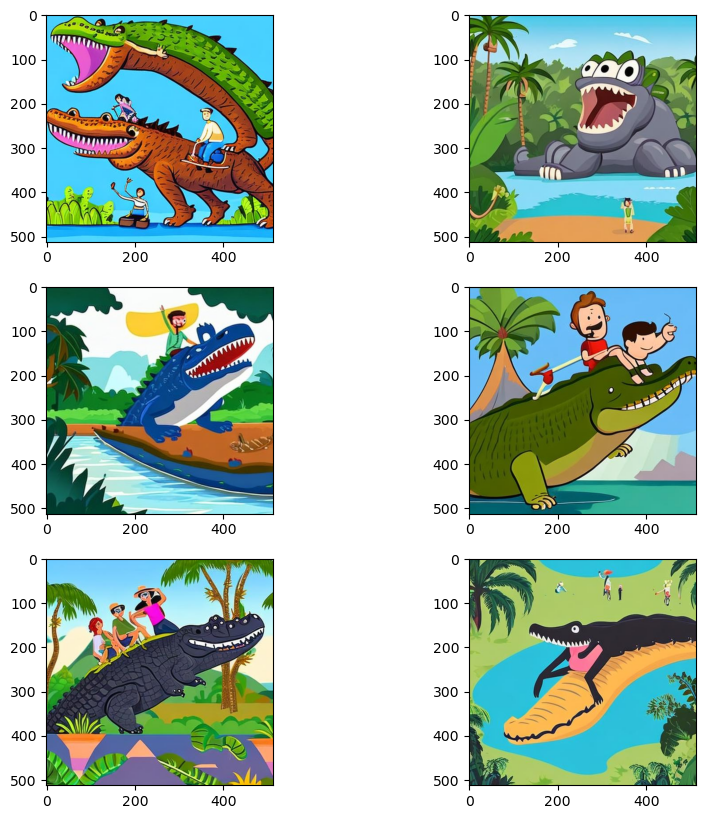

In [35]:
%matplotlib inline

import io
import time
from PIL import Image
import matplotlib.pyplot as plt
from multiprocessing.pool import ThreadPool

# adjust this number according to the instance size and number of workers
num_clients = num_workers
input_req = {
    "prompt": "giant crocodile in jungles with people riding on its back; cartoon style",
    # more info about these 2 params here: https://huggingface.co/blog/stable_diffusion
    "num_inference_steps": 25,
    "guidance_scale": 7.5
}
input_reqs = [input_req] * num_clients

def predict(req):    
    data = predictor.predict(req)
    return data

print("The model latency per prediction in BF16 is ~2.01s (50 iterations) ~1.26s (25 iterations).")
print("The time you'll get here also includes IO (data transfer in and out). You can reduce that by defining a VPC-endpoint in the PyTorchModel above.")
with ThreadPool(num_clients) as p:
    t = time.time()
    data = p.map(predict, input_reqs)
    print(f"{len(data)} images generated in {(time.time()-t):0.2f}s.")

fig = plt.figure(figsize=(10, 10))
columns = 2
rows = 3
j = 0
for i in range(1, columns*rows +1):    
    fig.add_subplot(rows, columns, i)
    plt.imshow(Image.open(io.BytesIO(data[j])))
    j += 1
plt.show()

### Delete the endpoint (manually or scheduled)

In [36]:
import time

last_cell_timestamp = time.time()

If you're running the notebook with "Run All Cells" command, the above cell and the below cell will be executed automatically one by one and the endpoint will stay active for you to experiment with. It will incur additional hourly charges.

However, if you run the below cell manually again after some time depending on the `grace_period_seconds` variable, the endpoint will be gracefully deleted and no further charges will occur.

If you forget to delete the endpoint manually, but will keep the notebook kernel instance up and running, the endpoint will be deleted by the background thread depending on the `auto_delete_hours` variable.

In [37]:
import threading
import botocore.exceptions

seconds_since_last_cell_timestamp = int(time.time() - last_cell_timestamp)
grace_period_seconds = 30
auto_delete_hours = 8.0

def delete_endpoint():
    try:
        predictor.delete_endpoint(delete_endpoint_config=False)
    except botocore.exceptions.ClientError as e:
        # Most likely, already deleted
        print(e)
        pass
    print("Endpoint has been deleted.")
    
def schedule_auto_delete():
    global auto_delete_timer
    try:
        print("Cancelling previous timer...")
        auto_delete_timer.cancel()
    except NameError:
        print("Timer hasn't been yet defined.")
        print(f"Scheduling the automatic deletion in {auto_delete_hours} hours.")
    else:
        print("Timer is cancelled.")
        print(f"Re-scheduling the automatic deletion in {auto_delete_hours} hours.")
    auto_delete_timer = threading.Timer(auto_delete_hours * 60 * 60, delete_endpoint)
    auto_delete_timer.start()    

print("Checking notebook for automated run...")
print(f"Seconds since last cell exectution: {seconds_since_last_cell_timestamp}")
if seconds_since_last_cell_timestamp > grace_period_seconds:
    print("Cell is executed manually. Deleting endpoint.")
    delete_endpoint()
else:
    print("Cell is executed automatically. Skipping endpoint delete. Don't forget to run the cell again to delete endpoint manually.")
    schedule_auto_delete()

Checking notebook for automated run...
Seconds since last cell exectution: 2
Cell is executed automatically. Skipping endpoint delete. Don't forget to run the cell again to delete endpoint manually.
Cancelling previous timer...
Timer is cancelled.
Re-scheduling the automatic deletion in 8.0 hours.


If you don't want to delete the endpoint right now, but want to extend the automatic deletion instead, run the below cell manually. The countdown for automatic deletion will start over.

In [38]:
seconds_since_last_cell_timestamp = int(time.time() - last_cell_timestamp)
print(f"Seconds since last cell exectution: {seconds_since_last_cell_timestamp}")

if seconds_since_last_cell_timestamp > grace_period_seconds:
    print(f"Cell is executed manually. Re-scheduling the timer.")
    schedule_auto_delete()
else:
    print("Cell is executed automatically. Skipping re-scheduling. Run the cell again to re-schedule deletion.")

Seconds since last cell exectution: 7
Cell is executed automatically. Skipping re-scheduling. Run the cell again to re-schedule deletion.
